# Concatenation of .csv files

---

**Updated on:** 2023-09-15

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): folder of .csv files to be concatenated  
> Output file(s): concatenated .csv file  
> Dependencies: pandas, pathlib, matplotlib, numpy, ipympl, sys

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

## Importing Dependencies

In [1]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import sys
sys.path.append(r"..")
import microspot_util as msu
import microspot_util.plots as plots
%matplotlib widget

2023-11-29 15:50:01.586 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-29 15:50:01.609 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-29 15:50:01.625 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-29 15:50:01.629 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-29 15:50:01.634 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-29 15:50:01.638 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## User Input

In [2]:
# Input Folder containing all .csv spot files with the ending "spotlist.csv".
input_folder=Path(r"../output")

# Folder that the output should be saved to.
output_folder=Path(r"../output")

RT_start=61               # RT @ which spotting was started
RT_end=300                # RT @ which spotting was stopped


## Data Merging and RT Matching

In [3]:
# Loop over all files in the folder that should be concatenated.
merged_spots=[]
for file in input_folder.glob("*spotlist.csv"):
    # Create list of spot-objects from .csv
    current_list=msu.spot.df_to_list(pd.read_csv(file))
    # Add to merged spot-list
    merged_spots.extend(current_list)

# Extract information on first and last spot
first_spot=merged_spots[0].row_name+str(merged_spots[0].col)
last_spot=merged_spots[-1].row_name+str(merged_spots[-1].col)

# Sort the newly merged spot-list by rows and columns. If serpentine = True, even rows are sorted descendingly.
msu.spot.sort_list(merged_spots,serpentine=True,inplace=True)

# Annotates each spot with a retention time based on the input parameters.
msu.spot.annotate_RT(merged_spots,RT_start,RT_end)

# Create df from list
concat_df=msu.spot.create_df(merged_spots)

# Baseline correction of activity chromatogram
baseline,concat_df.norm_intensity=msu.baseline_correction(concat_df.norm_intensity)

## Heatmap of concatenated spotlist

2023-11-29 15:50:03.190 
  command:

    streamlit run /home/nesiron/anaconda3/envs/petras/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-11-29 15:50:03.193 No runtime found, using MemoryCacheStorageManager


,row,row_name,column,type,x_coord,y_coord,radius,halo,spot_intensity,norm_intensity,note,RT
0,1,A,1,Sample,106,69,25,NaN,0.713319,0.005914,Initial Detection,61.0
1,1,A,2,Sample,210,70,26,NaN,0.713298,0.025738,Initial Detection,62.0
2,1,A,3,Sample,322,74,20,NaN,0.721128,0.035483,Initial Detection,63.0
3,1,A,4,Sample,421,73,23,NaN,0.788749,0.120198,Initial Detection,64.0
4,1,A,5,Sample,531,77,23,NaN,0.993517,0.396002,Backfilled,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,12,L,5,Sample,509,1401,25,NaN,0.723516,0.000966,Initial Detection,296.0
236,12,L,4,Sample,402,1400,22,NaN,0.727154,0.007705,Initial Detection,297.0
237,12,L,3,Sample,296,1400,24,NaN,0.720843,0.001258,Initial Detection,298.0
238,12,L,2,Sample,193,1396,20,NaN,0.720028,0.002559,Initial Detection,299.0


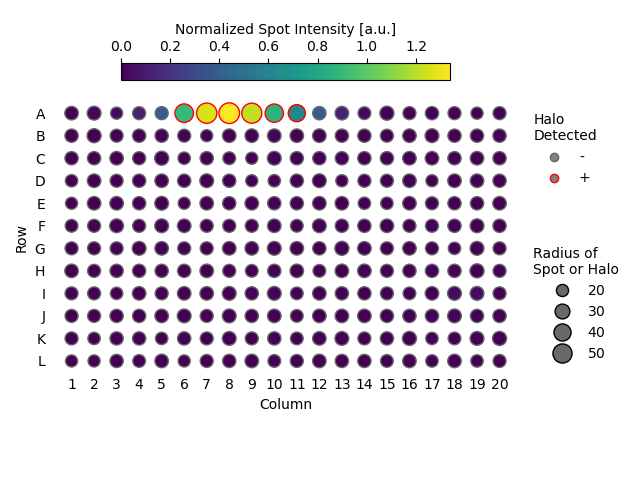

In [4]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

# Get the grid-properties of the spotlist.
grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

# Plot the heatmap of the merged data, uses normalized data if norm_data is set to True.
fig1,ax1=plt.subplots()
plots.plot_heatmapv2(
    fig1,
    ax1,
    concat_df,
    row_conv_inv,
    norm_data=True,
    halo=True
    )
concat_df

## Chromatogram

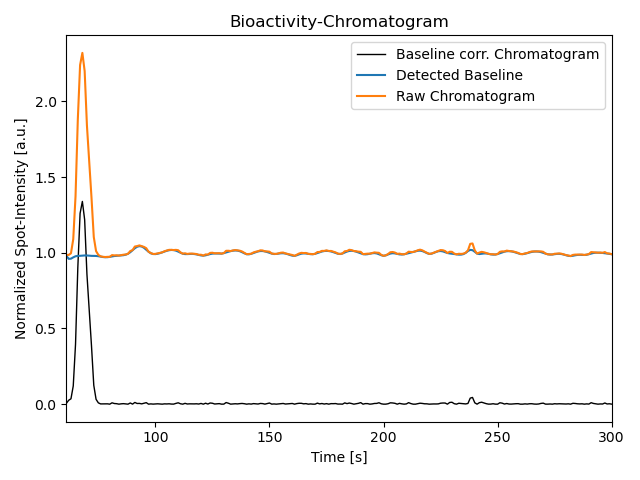

In [5]:
# Plot the chromatogram, uses normalized data if norm_data is set to True.
fig,ax=plt.subplots()
plots.plot_chromatogram(fig,ax,concat_df,norm_data=True)
ax.plot(concat_df.RT,baseline)
ax.plot(concat_df.RT,baseline+concat_df.norm_intensity)
ax.legend(["Baseline corr. Chromatogram","Detected Baseline","Raw Chromatogram"])

## Save output-files.

In [6]:
# Write to file.
output_filename=output_folder / Path(input_folder.name+"_concat.csv")
concat_df.to_csv(output_filename)